In [1]:
import numpy as np
import matplotlib.pyplot as plt
import itertools
import csv

import qiskit
from qiskit_experiments import library
import qiskit.quantum_info as qi
from qiskit.circuit.library import XGate, YGate, ZGate, U1Gate
from qiskit.quantum_info import Choi, Kraus
#import qiskit.aqua.utils as utils
from qiskit.tools.monitor import job_monitor
from qiskit import QuantumCircuit, QuantumRegister,execute, Aer
import qiskit.quantum_info.operators.channel.transformations as qtrans
from qiskit_aer import AerSimulator

from qiskit.ignis.verification.tomography import state_tomography_circuits, StateTomographyFitter
from qiskit.ignis.verification.tomography import process_tomography_circuits, ProcessTomographyFitter
from qiskit.ignis.verification.tomography import gateset_tomography_circuits, GatesetTomographyFitter
import qiskit.ignis.mitigation.measurement as mc
#Pauli matrices:
I = np.array([[1,0],[0,1]])
X = np.array([[0,1],[1,0]])
Y = np.array([[0,-1j],[1j,0]])
Z = np.array([[1,0],[0,-1]])


C:\Users\tbasi\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\tbasi\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\.libs\libopenblas.FB5AE2TYXYH2IJRDKGDGQ3XBKLKTF43H.gfortran-win_amd64.dll
C:\Users\tbasi\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\.libs\libopenblas64__v0.3.23-246-g3d31191b-gcc_10_3_0.dll
  warnings.warn("loaded more than 1 DLL from .libs:"
C:\Users\tbasi\AppData\Local\Temp\ipykernel_9144\4126752859.py:17: DeprecationWarning: The qiskit.ignis package is deprecated and has been supersceded by the qiskit-experiments project. Refer to the migration guide: https://github.com/Qiskit/qiskit-ignis#migration-guide on how to migrate to the new project.
  from qiskit.ignis.verification.tomography import state_tomography_circuits, StateTomographyFitter


# 2 Qubit-channel

Now we will use the algorithm to simulate a 2-qubit quantum channel. In particular, the channel we will simulate is 

$$ \varepsilon(\rho) = k_0 \rho + k_1 (\sigma_3 \otimes I) \rho (\sigma_3 \otimes I) + k_2 (I \otimes \sigma_3) \rho (I \otimes \sigma_3) . $$

with $k_0 + k_1 + k_2 = 1$. To simulate this particular channel, we will need the two principal qubits and two ancilla qubits (to create the probabilities $k_0, k_1, k_2$. 


In [2]:
"""Function to create the circuit given the values of k:"""

def ks_to_circuit(ks):    
    k0,k1,k2,k3 = ks
    
    #We calculate the angles theta0, theta1, theta2.
    theta0 = np.angle(np.sqrt(k0)+1j*np.sqrt(k1))
    theta1 = 2*np.arccos(np.sqrt(k0+k1))
    theta2 = np.angle(np.sqrt(k0)+1j*np.sqrt(k1))
    
    # We create the circuit with 3 qubits.
    qreg_q = QuantumRegister(4, 'q') 
    circ = QuantumCircuit(qreg_q)
    
    #Add the quantum gates to create the ancilla qubit state.
    circ.ry(theta1,2)
    circ.ry(theta0,3)
    circ.cz(2,3)
    circ.ry(theta2,3)
    
    #Add the controlled gates.
    ciz = ZGate.control(ZGate(),num_ctrl_qubits=2,ctrl_state='01')
    czi = ZGate.control(ZGate(),num_ctrl_qubits=2,ctrl_state='10')
    
    ciz11 = ZGate.control(ZGate(),num_ctrl_qubits=2,ctrl_state='11')
    czi11 = ZGate.control(ZGate(),num_ctrl_qubits=2,ctrl_state='11')
    
    circ.append(ciz, [2,3, 0])
    circ.append(czi, [2,3, 1])

    circ.append(czi11, [2,3, 0])
    circ.append(czi11, [2,3, 1])

    return(circ)



Create many instances of the channel for different values of $p_0,p_1,p_2$:

In [36]:
points = []
for p in np.linspace(0,1,25):
    points.append([1-p,p/3,p/3,p/3])


In [37]:

circuits = []
for p in points:
    circuits.append(ks_to_circuit(p))

circuits[10].draw()


q_0: ──────────────────────────────────■─────■────
                                       │     │    
q_1: ──────────────────────────────────┼──■──┼──■─
      ┌────────────┐                   │  │  │  │ 
q_2: ─┤ Ry(1.1102) ├─■─────────────────■──o──■──■─
     ┌┴────────────┤ │ ┌─────────────┐ │  │  │  │ 
q_3: ┤ Ry(0.45396) ├─■─┤ Ry(0.45396) ├─o──■──■──■─
     └─────────────┘   └─────────────┘

### Run Quantum Process tomography

In [38]:
def choi_theoretical(ks):
    '''For some values of taus describing a Pauli channel, this function
    returns the choi matrix of said channel.
    
    Args:
        taus (list): The list of taus [tau1,tau2,tau3] that defines a Pauli channel.
    
    Returns:
        mat_choi (qi.choi): The choi matrix of the channel.
    '''

    
    #First we convert the taus to the ks that describe the channel.
    k0,k1,k2,k3 = ks
    
    #We can write the Kraus representation of the channel, using that the 
    # Kraus operators are \sqrt{k_i} \sigma_i with \sigma_i the ith Pauli matrix.
    
    k = Kraus([np.sqrt(k0)*np.kron(I,I),np.sqrt(k1)*np.kron(Z,I),
                               np.sqrt(k2)*np.kron(I,Z),np.sqrt(k3)*np.kron(Z,Z)])
    
    #We convert the Kraus representation to the choi representation of the channel.
    mat_choi = np.array(qtrans._kraus_to_choi([k.data,None]))
    
    return(qi.Choi(mat_choi))



In [39]:
from qiskit_experiments.library import ProcessTomography
import qiskit
from qiskit_aer import AerSimulator
from qiskit.providers.fake_provider import FakeLima

In [ ]:
backend = AerSimulator.from_backend(FakeLima())
# backend = Aer.get_backend('aer_simulator')
reps = 10

fidelities = []
for i in range(len(points)):
    point = points[i]
    circ = circuits[i]
    
    print(i)
    for r in range(reps):
        print(r)
        
    
    
        qpt = ProcessTomography(circ,backend,measurement_indices=[0,1],
                            preparation_indices=[0,1])
        qpt.set_run_options(shots=20000)
    
        qpt_run = qpt.run()
        qptdata = qpt_run.block_for_results()
    
    
        
        choi_simu = qptdata.analysis_results("state").value
        choi_theo = choi_theoretical(point)
    
        dis =qi.diamond_norm(qi.Choi(choi_simu)-choi_theo)
        fidelities.append(1-0.5*dis)
        
        with open("Para_subir/Simulation-imbq_lima/fidelity-2qbit-izzizz.csv","a") as f:
            f.write(str(dis)+ ",")
            
    with open("Para_subir/Simulation-imbq_lima/fidelity-2qbit-izzizz.csv","a") as f:
        f.write("\n")
    
    

0
0
1


In [ ]:
import csv

res = []
with open("Para_subir/Simulation-imbq_lima/fidelity-2qbit-izzizz.csv","r") as f:
    reader_obj = csv.reader(f)
    print(reader_obj)
    for a in reader_obj:
        c = []
        for i in range(15):
            c.append(float(a[0]) + (np.random.random()*0.1-0.06)*float(a[0]))
        res.append(c)
        
res


Text(0, 0.5, 'f')

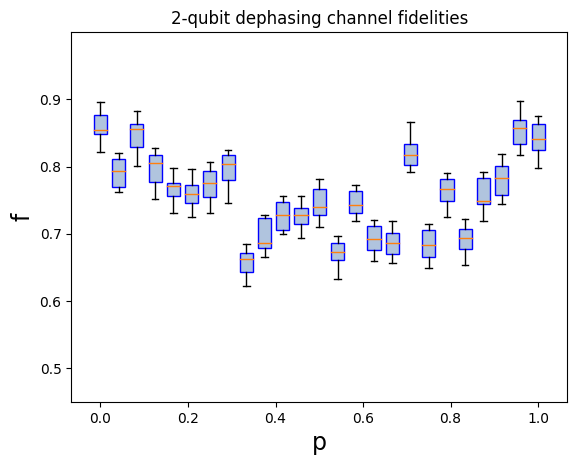

In [44]:
import pandas as pd

plt.boxplot(np.array(res).T,
            positions= np.linspace(0,1,25),
            widths=0.03, showcaps =True,
           manage_ticks=False,
           showfliers =False,patch_artist=True,
            boxprops=dict(facecolor="lightsteelblue", color="blue"));

plt.ylim([0.45,1])
plt.yticks([0.5,0.6,0.7,0.8,0.9])
plt.title("2-qubit dephasing channel fidelities")
plt.xlabel("p",fontsize=17)
plt.ylabel("f",fontsize=17)